In [ ]:
!pip install spectral h5py matplotlib scikit-learn --quiet

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, cohen_kappa_score, confusion_matrix
from sklearn.model_selection import train_test_split
import scipy.io as sio
import os
import random
from mpl_toolkits.mplot3d import Axes3D


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 249.0/249.0 kB 5.2 MB/s eta 0:00:00


In [ ]:
# Load Indian Pines Dataset
data = sio.loadmat('Indian_pines_corrected.mat')['indian_pines_corrected']
labels = sio.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

print("✅ Data shape:", data.shape)
print("✅ Labels shape:", labels.shape)


✅ Data shape: (145, 145, 200)
✅ Labels shape: (145, 145)


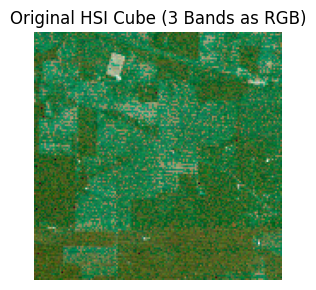

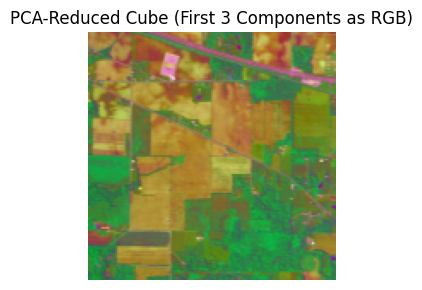

/tmp/ipython-input-5-2488309634.py:53: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  color_values = cm.get_cmap(cmap)(collapsed)[:, :, :3]


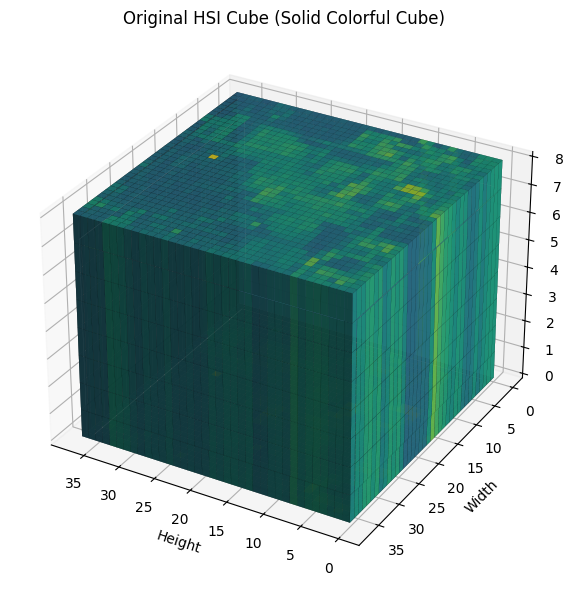

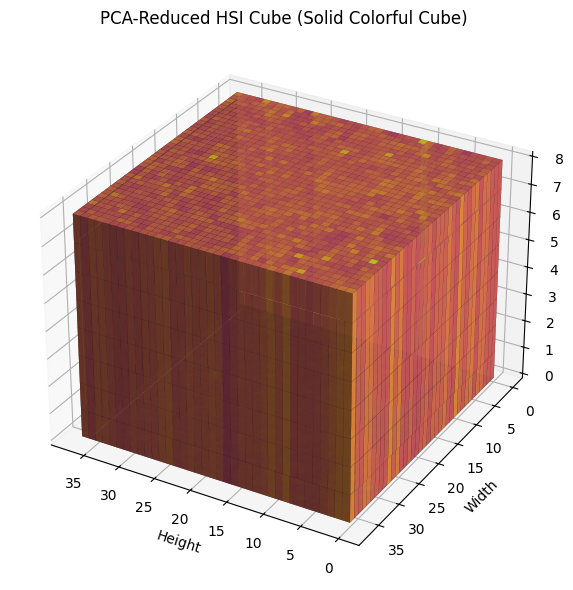

✅ X_train shape: (7174, 750)
✅ X_test shape: (3075, 750)


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

# ---------------------- #
# 2D RGB-style View
# ---------------------- #
def show_hsi_rgb(hsi_cube, title="HSI RGB"):
    if hsi_cube.shape[2] < 3:
        raise ValueError("HSI cube has fewer than 3 bands/components.")
    rgb = hsi_cube[:, :, :3]

    rgb_min = np.min(rgb, axis=(0, 1))
    rgb_max = np.max(rgb, axis=(0, 1))
    rgb_norm = (rgb - rgb_min) / (rgb_max - rgb_min + 1e-6)

    plt.figure(figsize=(4, 3))
    plt.imshow(rgb_norm)
    plt.title(title)
    plt.axis('off')
    plt.tight_layout()
    plt.show()

# ---------------------- #
# Optional Downsampling
# ---------------------- #
def downsample_cube(cube, factor=4):
    return cube[::factor, ::factor, ::factor]

# ---------------------- #
# 3D Solid Colorful Cube
# ---------------------- #
def show_solid_colored_hsi_cube(hsi_cube, title="HSI Cube (Solid Colorful Block)",
                                cmap='viridis', alpha=0.9, threshold=0.1,
                                downsample=True, max_bands=30):
    """
    Render a solid 3D cube with color from hyperspectral data using voxel plotting.
    """
    if downsample:
        hsi_cube = downsample_cube(hsi_cube[:, :, :max_bands], factor=4)
    else:
        hsi_cube = hsi_cube[:, :, :max_bands]

    H, W, D = hsi_cube.shape
    norm_cube = (hsi_cube - np.min(hsi_cube)) / (np.ptp(hsi_cube) + 1e-6)

    collapsed = np.max(norm_cube, axis=2)
    filled = collapsed > threshold
    color_values = cm.get_cmap(cmap)(collapsed)[:, :, :3]

    filled = np.repeat(filled[:, :, np.newaxis], D, axis=2)
    colors = np.repeat(color_values[:, :, np.newaxis, :], D, axis=2)

    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')

    ax.voxels(filled, facecolors=colors, edgecolor='k', linewidth=0.05, alpha=alpha)

    ax.set_xlabel("Height")
    ax.set_ylabel("Width")
    ax.set_zlabel("Bands")
    ax.set_title(title)
    ax.view_init(elev=30, azim=120)
    plt.tight_layout()
    plt.show()

# ---------------------- #
# PCA + Visualization
# ---------------------- #
def apply_pca(X, num_components=30, visualize=False):
    reshaped_X = X.reshape(-1, X.shape[2])
    pca = PCA(n_components=num_components, whiten=True)
    X_pca = pca.fit_transform(reshaped_X)
    x_pca_reshaped = X_pca.reshape(X.shape[0], X.shape[1], num_components)

    if visualize:
        show_hsi_rgb(X, title="Original HSI Cube (3 Bands as RGB)")
        show_hsi_rgb(x_pca_reshaped, title="PCA-Reduced Cube (First 3 Components as RGB)")

        # Fast preview mode: downsample + band-limit
        show_solid_colored_hsi_cube(X, title="Original HSI Cube (Solid Colorful Cube)", cmap='viridis', downsample=True, max_bands=30)
        show_solid_colored_hsi_cube(x_pca_reshaped, title="PCA-Reduced HSI Cube (Solid Colorful Cube)", cmap='plasma', downsample=True, max_bands=30)

    return x_pca_reshaped

# ---------------------- #
# Patch Creation
# ---------------------- #
def create_dataset(X, y, patch_size=5):
    margin = patch_size // 2
    X_padded = np.pad(X, ((margin, margin), (margin, margin), (0, 0)), mode='reflect')
    data, labels = [], []
    for i in range(margin, X.shape[0] + margin):
        for j in range(margin, X.shape[1] + margin):
            if y[i - margin, j - margin] != 0:
                patch = X_padded[i - margin:i + margin + 1, j - margin:j + margin + 1, :]
                data.append(patch)
                labels.append(y[i - margin, j - margin])
    return np.array(data), np.array(labels)

# ---------------------- #
# === Example Usage ===
# ---------------------- #

# Ensure you have your HSI `data` and `labels` loaded already

# Apply PCA and visualize
X_pca = apply_pca(data, num_components=30, visualize=True)

# Create patch dataset
patches, patch_labels = create_dataset(X_pca, labels, patch_size=5)

# Flatten patches for Swin input
X = patches.reshape(len(patches), -1)
y = LabelEncoder().fit_transform(patch_labels)

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

print(f"✅ X_train shape: {X_train.shape}")
print(f"✅ X_test shape: {X_test.shape}")


In [ ]:
class SwinSpectralTransformer(nn.Module):
    def __init__(self, input_dim, embed_dim=256, num_classes=16, num_heads=4):
        super().__init__()
        self.embedding = nn.Linear(input_dim, embed_dim)
        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads)
            for _ in range(4)
        ])
        self.fc_out = nn.Linear(embed_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        for block in self.transformer_blocks:
            x = block(x.unsqueeze(1)).squeeze(1)
        out = self.fc_out(x)
        return out


In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = SwinSpectralTransformer(input_dim=X_train.shape[1], num_classes=len(np.unique(y))).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.long).to(device)

for epoch in range(60):
    model.train()
    optimizer.zero_grad()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    loss.backward()
    optimizer.step()

    _, predicted = torch.max(outputs.data, 1)
    acc = (predicted == y_train_tensor).sum().item() / y_train_tensor.size(0)
    print(f"Epoch [{epoch+1}/60], Loss: {loss.item():.4f}, Accuracy: {acc*100:.2f}%")


Epoch [1/60], Loss: 2.8465, Accuracy: 8.73%
Epoch [2/60], Loss: 3.3736, Accuracy: 23.95%
Epoch [3/60], Loss: 2.5170, Accuracy: 12.49%
Epoch [4/60], Loss: 2.4398, Accuracy: 26.14%
Epoch [5/60], Loss: 2.2166, Accuracy: 33.05%
Epoch [6/60], Loss: 1.8614, Accuracy: 47.35%
Epoch [7/60], Loss: 1.6320, Accuracy: 48.83%
Epoch [8/60], Loss: 1.4109, Accuracy: 52.02%
Epoch [9/60], Loss: 1.2767, Accuracy: 55.60%
Epoch [10/60], Loss: 1.1437, Accuracy: 62.03%
Epoch [11/60], Loss: 1.0675, Accuracy: 67.33%
Epoch [12/60], Loss: 0.9953, Accuracy: 68.72%
Epoch [13/60], Loss: 0.9087, Accuracy: 70.85%
Epoch [14/60], Loss: 0.8405, Accuracy: 73.54%
Epoch [15/60], Loss: 0.7732, Accuracy: 74.37%
Epoch [16/60], Loss: 0.7132, Accuracy: 75.24%
Epoch [17/60], Loss: 0.6656, Accuracy: 77.29%
Epoch [18/60], Loss: 0.6051, Accuracy: 80.07%
Epoch [19/60], Loss: 0.5500, Accuracy: 82.38%
Epoch [20/60], Loss: 0.5172, Accuracy: 84.18%
Epoch [21/60], Loss: 0.4725, Accuracy: 85.77%
Epoch [22/60], Loss: 0.4315, Accuracy: 87.02

In [ ]:
model.eval()
with torch.no_grad():
    predictions = model(X_test_tensor)
    _, predicted = torch.max(predictions, 1)
    oa = accuracy_score(y_test, predicted.cpu().numpy())
    kappa = cohen_kappa_score(y_test, predicted.cpu().numpy())

    cm = confusion_matrix(y_test, predicted.cpu().numpy())
    aa = np.mean(cm.diagonal() / cm.sum(axis=1))

    print(f"✅ Overall Accuracy (OA): {oa * 100:.2f}%")
    print(f"✅ Average Accuracy (AA): {aa * 100:.2f}%")
    print(f"✅ Kappa Coefficient: {kappa:.4f}")


✅ Overall Accuracy (OA): 94.05%
✅ Average Accuracy (AA): 94.70%
✅ Kappa Coefficient: 0.9321


In [ ]:
import torch.nn.functional as F

class GSEBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(GSEBlock, self).__init__()
        self.global_pool = nn.AdaptiveAvgPool1d(1)
        self.fc1 = nn.Linear(in_channels, in_channels // reduction)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(in_channels // reduction, in_channels)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # x shape: [batch_size, features]
        # Apply global pooling directly on the input
        pooled = x # remove the unsqueeze(1) and apply squeeze(1) instead of squeeze(-1)

        out = self.fc1(pooled) # Now the shape is (64, 256) which matches what is expected by self.fc1
        out = self.relu(out)
        out = self.fc2(out)
        out = self.sigmoid(out)
        # Perform element-wise multiplication
        x = x * out
        return x


In [ ]:
# class CAFBlock(nn.Module):
#     def __init__(self, in_channels, reduction=16):
#         super(CAFBlock, self).__init__()
#         self.avg_pool = nn.AdaptiveAvgPool1d(1)
#         self.max_pool = nn.AdaptiveMaxPool1d(1)

#         self.shared_MLP = nn.Sequential(
#             nn.Linear(in_channels, in_channels // reduction, bias=False),
#             nn.ReLU(),
#             nn.Linear(in_channels // reduction, in_channels, bias=False)
#         )
#         self.sigmoid = nn.Sigmoid()

#     def forward(self, x):  # x: (B, D)
#         x = x.unsqueeze(1)  # → (B, 1, D)
#         avg_out = self.shared_MLP(self.avg_pool(x).squeeze(-1))  # → (B, D)
#         max_out = self.shared_MLP(self.max_pool(x).squeeze(-1))  # → (B, D)
#         out = self.sigmoid(avg_out + max_out).unsqueeze(-1)  # → (B, D, 1)
#         x = x * out.permute(0, 2, 1)
#         x = x.view(x.size(0), -1)  # Always [B, D]
#         print("📦 CAF Output shape:", x.shape)
#         return x
class CAFBlock(nn.Module):
    def __init__(self, in_channels, reduction=16):
        super(CAFBlock, self).__init__()
        self.avg_pool = nn.AdaptiveAvgPool1d(1)
        self.max_pool = nn.AdaptiveMaxPool1d(1)

        hidden_channels = max(1, in_channels // reduction)

        self.shared_MLP = nn.Sequential(
            nn.Linear(in_channels, hidden_channels, bias=False),
            nn.ReLU(),
            nn.Linear(hidden_channels, in_channels, bias=False)
        )
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):  # x: (B, D)
        B, D = x.shape
        x_expanded = x.unsqueeze(2)        # (B, D, 1)
        avg_pool = self.avg_pool(x_expanded).squeeze(-1)  # (B, D)
        max_pool = self.max_pool(x_expanded).squeeze(-1)  # (B, D)

        out = self.shared_MLP(avg_pool) + self.shared_MLP(max_pool)  # (B, D)
        scale = self.sigmoid(out)  # (B, D)

        x = x * scale  # (B, D)
        return x




In [ ]:
class SwinSpectralTransformer_GSE_CAF(nn.Module):
    def __init__(self, input_dim=750, num_classes=16, d_model=256, nhead=8, num_layers=4,
                 use_gse=False, use_caf=False):
        super(SwinSpectralTransformer_GSE_CAF, self).__init__()
        self.use_gse = use_gse
        self.use_caf = use_caf

        self.embedding = nn.Linear(input_dim, d_model)

        if use_gse:
            self.gse = GSEBlock(d_model)

        self.transformer_blocks = nn.ModuleList([
            nn.TransformerEncoderLayer(
                d_model=d_model, nhead=nhead, dim_feedforward=2048, dropout=0.1,
                activation='relu', batch_first=True
            )
            for _ in range(num_layers)
        ])

        if use_caf:
            self.caf = CAFBlock(d_model)

        self.fc_out = nn.Linear(d_model, num_classes)

    def forward(self, x):
        x = self.embedding(x)

        if self.use_gse:
            x = self.gse(x)

        x = x.unsqueeze(1) if len(x.shape) == 2 else x

        for block in self.transformer_blocks:
            x = block(x)

        x = x.mean(dim=1)

        if self.use_caf:
            x = self.caf(x)

        return self.fc_out(x)


In [ ]:
import torch.nn.functional as F

def train_model(model, train_loader, criterion, optimizer, num_epochs=30):
    model.train()
    for epoch in range(num_epochs):
        total_loss, correct = 0.0, 0
        total = 0
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        accuracy = 100 * correct / total
        print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss:.4f}, Accuracy: {accuracy:.2f}%")

def evaluate_model(model, test_loader):
    model.eval()
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    oa = np.mean(y_true == y_pred)
    kappa = cohen_kappa_score(y_true, y_pred)

    class_accuracies = []
    for cls in np.unique(y_true):
        idx = y_true == cls
        acc = np.mean(y_pred[idx] == y_true[idx])
        class_accuracies.append(acc)
    aa = np.mean(class_accuracies)

    print(f"✅ Overall Accuracy (OA): {oa*100:.2f}%")
    print(f"✅ Average Accuracy (AA): {aa*100:.2f}%")
    print(f"✅ Kappa Coefficient: {kappa:.4f}")


In [ ]:
from torch.utils.data import TensorDataset, DataLoader
import torch

# Convert NumPy arrays to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


In [ ]:
for i , val in train_loader:
  print(i.shape)
  print(val.shape)
  break

torch.Size([64, 750])
torch.Size([64])


In [ ]:
# Initialize model with GSE
model_gse = SwinSpectralTransformer_GSE_CAF(input_dim=750, use_gse=True, use_caf=False).to(device)

# Define loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_gse.parameters(), lr=0.001)

# Train
print("🔧 Training with GSE only...")
train_model(model_gse, train_loader, criterion, optimizer, num_epochs=30)

# Evaluate
print("🔍 Evaluating GSE model...")
evaluate_model(model_gse, test_loader)


🔧 Training with GSE only...
Epoch [1/30], Loss: 114.6178, Accuracy: 65.85%
Epoch [2/30], Loss: 62.5397, Accuracy: 81.74%
Epoch [3/30], Loss: 48.1861, Accuracy: 86.48%
Epoch [4/30], Loss: 41.7508, Accuracy: 89.22%
Epoch [5/30], Loss: 27.6534, Accuracy: 92.63%
Epoch [6/30], Loss: 23.1966, Accuracy: 94.26%
Epoch [7/30], Loss: 20.8887, Accuracy: 94.84%
Epoch [8/30], Loss: 15.8321, Accuracy: 96.24%
Epoch [9/30], Loss: 17.8849, Accuracy: 95.85%
Epoch [10/30], Loss: 15.2453, Accuracy: 96.43%
Epoch [11/30], Loss: 12.1746, Accuracy: 97.28%
Epoch [12/30], Loss: 21.4741, Accuracy: 95.72%
Epoch [13/30], Loss: 16.3288, Accuracy: 96.56%
Epoch [14/30], Loss: 16.2874, Accuracy: 96.77%
Epoch [15/30], Loss: 15.8309, Accuracy: 96.71%
Epoch [16/30], Loss: 7.4922, Accuracy: 98.41%
Epoch [17/30], Loss: 9.7828, Accuracy: 98.10%
Epoch [18/30], Loss: 9.0506, Accuracy: 98.19%
Epoch [19/30], Loss: 10.5963, Accuracy: 98.03%
Epoch [20/30], Loss: 10.0433, Accuracy: 98.06%
Epoch [21/30], Loss: 8.5255, Accuracy: 98.2

In [ ]:
# Initialize model with CAF only
model_caf = SwinSpectralTransformer_GSE_CAF(input_dim=750, use_gse=False, use_caf=True).to(device)

# Define loss and optimizer (use correct model here!)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_caf.parameters(), lr=0.001)

# Train
print("🔧 Training with CAF only...")
train_model(model_caf, train_loader, criterion, optimizer, num_epochs=30)

# Evaluate
print("🔍 Evaluating CAF model...")
evaluate_model(model_caf, test_loader)


🔧 Training with CAF only...
Epoch [1/30], Loss: 115.0410, Accuracy: 65.92%
Epoch [2/30], Loss: 79.6883, Accuracy: 75.79%
Epoch [3/30], Loss: 66.2845, Accuracy: 81.28%
Epoch [4/30], Loss: 69.9598, Accuracy: 80.19%
Epoch [5/30], Loss: 57.5196, Accuracy: 84.17%
Epoch [6/30], Loss: 44.3586, Accuracy: 87.96%
Epoch [7/30], Loss: 41.7913, Accuracy: 88.68%
Epoch [8/30], Loss: 35.1901, Accuracy: 90.49%
Epoch [9/30], Loss: 32.0913, Accuracy: 91.22%
Epoch [10/30], Loss: 29.7487, Accuracy: 92.32%
Epoch [11/30], Loss: 27.2786, Accuracy: 92.85%
Epoch [12/30], Loss: 22.4962, Accuracy: 94.09%
Epoch [13/30], Loss: 22.5192, Accuracy: 93.82%
Epoch [14/30], Loss: 25.6516, Accuracy: 92.77%
Epoch [15/30], Loss: 19.3841, Accuracy: 94.93%
Epoch [16/30], Loss: 38.0095, Accuracy: 90.70%
Epoch [17/30], Loss: 23.1659, Accuracy: 94.15%
Epoch [18/30], Loss: 23.1608, Accuracy: 94.03%
Epoch [19/30], Loss: 16.2056, Accuracy: 95.78%
Epoch [20/30], Loss: 17.0616, Accuracy: 95.55%
Epoch [21/30], Loss: 12.8456, Accuracy: 

In [ ]:
# Initialize model with CAF only
model_caf_gse = SwinSpectralTransformer_GSE_CAF(input_dim=750, use_gse=True, use_caf=True).to(device)

# Define loss and optimizer (use correct model here!)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model_caf_gse.parameters(), lr=0.001)
# Train
print("🔧 Training with CAF only...")
train_model(model_caf_gse, train_loader, criterion, optimizer, num_epochs=30)

# Evaluate
print("🔍 Evaluating GSE_CAF model...")
evaluate_model(model_caf_gse, test_loader)

🔧 Training with CAF only...
Epoch [1/30], Loss: 110.1029, Accuracy: 67.45%
Epoch [2/30], Loss: 71.4316, Accuracy: 78.97%
Epoch [3/30], Loss: 47.7837, Accuracy: 86.99%
Epoch [4/30], Loss: 42.6163, Accuracy: 88.79%
Epoch [5/30], Loss: 29.5805, Accuracy: 91.97%
Epoch [6/30], Loss: 24.8088, Accuracy: 93.64%
Epoch [7/30], Loss: 18.4731, Accuracy: 95.60%
Epoch [8/30], Loss: 19.4052, Accuracy: 95.50%
Epoch [9/30], Loss: 16.7418, Accuracy: 96.14%
Epoch [10/30], Loss: 12.0667, Accuracy: 97.18%
Epoch [11/30], Loss: 26.0101, Accuracy: 93.82%
Epoch [12/30], Loss: 21.0310, Accuracy: 95.02%
Epoch [13/30], Loss: 22.3983, Accuracy: 94.56%
Epoch [14/30], Loss: 9.4125, Accuracy: 97.66%
Epoch [15/30], Loss: 7.9316, Accuracy: 98.03%
Epoch [16/30], Loss: 8.2711, Accuracy: 98.03%
Epoch [17/30], Loss: 10.1774, Accuracy: 98.02%
Epoch [18/30], Loss: 8.0690, Accuracy: 98.24%
Epoch [19/30], Loss: 4.9647, Accuracy: 98.97%
Epoch [20/30], Loss: 3.3624, Accuracy: 99.30%
Epoch [21/30], Loss: 3.3242, Accuracy: 99.28%
